In [1]:
pip install transformers datasets torch scikit-learn matplotlib peft

Note: you may need to restart the kernel to use updated packages.


In [2]:
 import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
import time

C:\Users\shubh\anaconda3\lib\site-packages\transformers\adapters\__init__.py:27: FutureWarning: The `adapter-transformers` package is deprecated and replaced by the `adapters` package. See https://docs.adapterhub.ml/transitioning.html.
  warnings.warn(


In [3]:

# Load spam dataset
spam_df = pd.read_csv('spam.csv', encoding='latin-1')
spam_df = spam_df.rename(columns={'v1': 'label', 'v2': 'text'})

# Map labels to integers
spam_df['label'] = spam_df['label'].map({'ham': 0, 'spam': 1})

# Only keep necessary columns
spam_df = spam_df[['text', 'label']].dropna()

# Check the size of the dataset
print(f"Dataset size: {len(spam_df)}")

# Reduce dataset size for quicker training if the dataset is large
if len(spam_df) > 10000:
    spam_df = spam_df.sample(n=10000, random_state=42)

dataset = Dataset.from_pandas(spam_df)
dataset = dataset.train_test_split(test_size=0.2)
dataset


Dataset size: 5572


DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 4457
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 1115
    })
})

In [4]:
# Define tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Function to tokenize data
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

C:\Users\shubh\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4457 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

In [5]:
# Metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)  # Convert logits to tensor
    acc = accuracy_score(labels, predictions)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec}


In [6]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Change from eval_strategy to evaluation_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [7]:
# Function to train and evaluate model
def train_and_evaluate(model, training_args, tokenized_datasets):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics,
    )
    
    start_time = time.time()
    trainer.train()
    train_time = time.time() - start_time
    
    start_time = time.time()
    eval_results = trainer.evaluate()
    eval_time = time.time() - start_time
    
    eval_results['train_time'] = train_time
    eval_results['eval_time'] = eval_time
    
    return eval_results

In [8]:
# Base Model without Soft Prompts or LoRA
base_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)
base_results = train_and_evaluate(base_model, training_args, tokenized_datasets)
print("Base Model Results:", base_results)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.we

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.019800,0.039201,0.991928,0.969072,0.972414,0.965753


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1115
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1115
  Batch size = 16


Base Model Results: {'eval_loss': 0.039200883358716965, 'eval_accuracy': 0.9919282511210762, 'eval_f1': 0.9690721649484535, 'eval_precision': 0.9724137931034482, 'eval_recall': 0.9657534246575342, 'eval_runtime': 250.0497, 'eval_samples_per_second': 4.459, 'eval_steps_per_second': 0.28, 'epoch': 1.0, 'train_time': 3047.671599626541, 'eval_time': 250.059711933136}


In [9]:
import torch.nn as nn

class SoftPromptModel(AutoModelForSequenceClassification):
    def __init__(self, config, num_labels, soft_prompt_length=20):
        super().__init__(config)
        self.num_labels = num_labels
        self.soft_prompt_length = soft_prompt_length
        self.soft_prompt_embed = nn.Embedding(self.soft_prompt_length, config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        soft_prompt=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

In [10]:

soft_prompt_model = SoftPromptModel.from_pretrained(model_checkpoint, num_labels=2)
soft_prompt_results = train_and_evaluate(soft_prompt_model, training_args, tokenized_datasets)
print("Soft Prompt Results:", soft_prompt_results)


C:\Users\shubh\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading configuration file config.json from cache at C:\Users\shubh/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.032600,0.034612,0.990135,0.962457,0.959184,0.965753


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1115
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1115
  Batch size = 16


Soft Prompt Results: {'eval_loss': 0.03461229056119919, 'eval_accuracy': 0.9901345291479821, 'eval_f1': 0.962457337883959, 'eval_precision': 0.9591836734693877, 'eval_recall': 0.9657534246575342, 'eval_runtime': 227.9528, 'eval_samples_per_second': 4.891, 'eval_steps_per_second': 0.307, 'epoch': 1.0, 'train_time': 2910.8580236434937, 'eval_time': 227.95892429351807}


In [12]:
from peft import get_peft_model, LoraConfig, TaskType

# Define LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification task
    r=8,                        # Low rank
    lora_alpha=32,              # Alpha parameter for LoRA
    lora_dropout=0.1,           # Dropout for LoRA
    bias="none",
    target_modules=["q_lin", "v_lin"] 
)

# Apply LoRA to the base model
lora_model = get_peft_model(AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2), lora_config)

# Train and evaluate the LoRA model
lora_results = train_and_evaluate(lora_model, training_args, tokenized_datasets)
print("LoRA Model Results:", lora_results)

loading configuration file config.json from cache at C:\Users\shubh/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at C:\Users\shubh/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\model.safetensors
Some weights of the model checkpoint at distilbert-base-uncased wer

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.193800,0.200096,0.871749,0.040268,1.000000,0.020548


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1115
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `PeftModelForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1115
  Batch size = 16


LoRA Model Results: {'eval_loss': 0.2000962644815445, 'eval_accuracy': 0.8717488789237668, 'eval_f1': 0.040268456375838924, 'eval_precision': 1.0, 'eval_recall': 0.02054794520547945, 'eval_runtime': 147.3047, 'eval_samples_per_second': 7.569, 'eval_steps_per_second': 0.475, 'epoch': 1.0, 'train_time': 1823.58278465271, 'eval_time': 147.31470489501953}


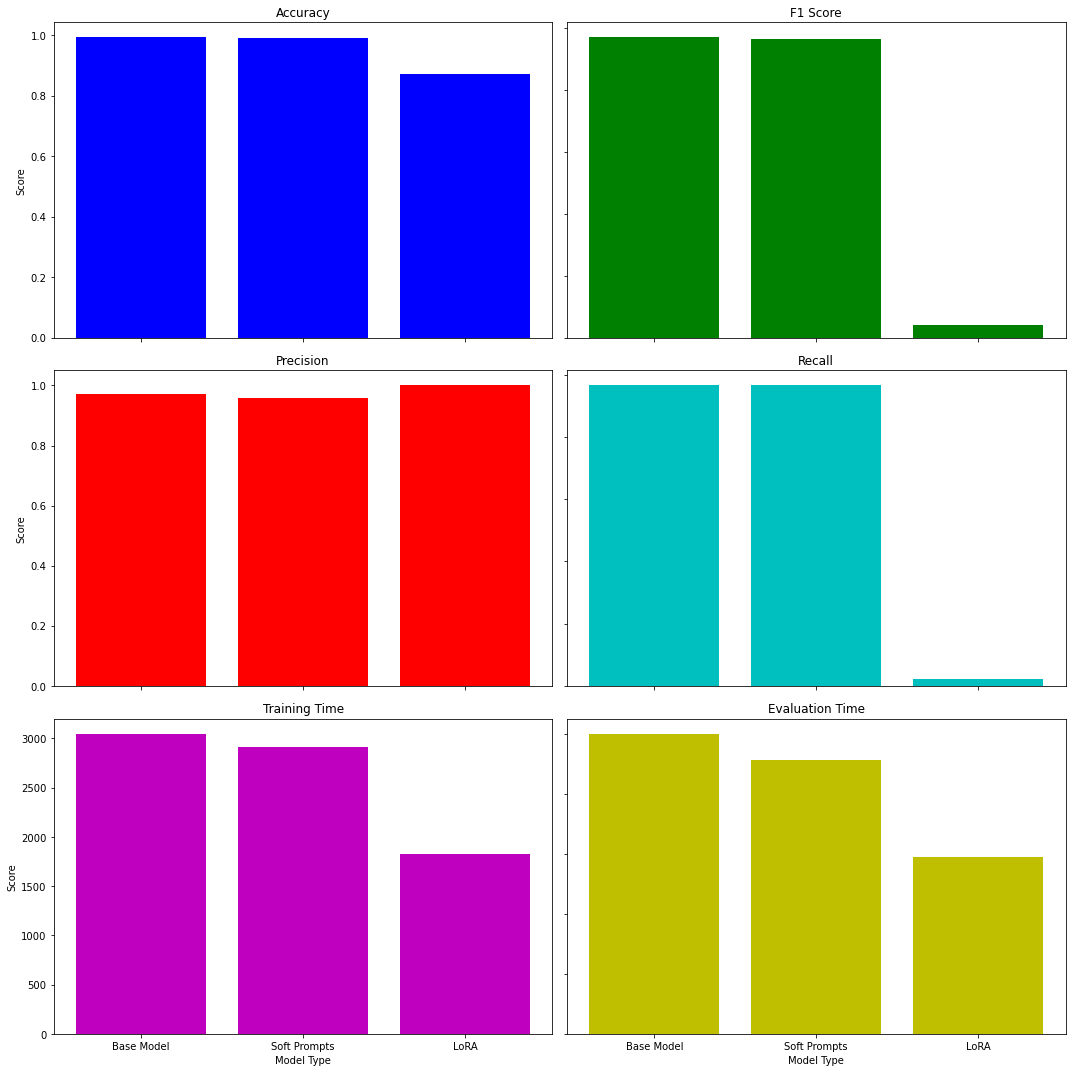

In [13]:
# Visualization
labels = ["Base Model", "Soft Prompts", "LoRA"]
accuracy = [base_results.get("eval_accuracy", 0), soft_prompt_results.get("eval_accuracy", 0), lora_results.get("eval_accuracy", 0)]
f1 = [base_results.get("eval_f1", 0), soft_prompt_results.get("eval_f1", 0), lora_results.get("eval_f1", 0)]
precision = [base_results.get("eval_precision", 0), soft_prompt_results.get("eval_precision", 0), lora_results.get("eval_precision", 0)]
recall = [base_results.get("eval_recall", 0), soft_prompt_results.get("eval_recall", 0), lora_results.get("eval_recall", 0)]
train_time = [base_results.get("train_time", 0), soft_prompt_results.get("train_time", 0), lora_results.get("train_time", 0)]
eval_time = [base_results.get("eval_time", 0), soft_prompt_results.get("eval_time", 0), lora_results.get("eval_time", 0)]

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].bar(labels, accuracy, color='b')
axs[0, 0].set_title('Accuracy')
axs[0, 1].bar(labels, f1, color='g')
axs[0, 1].set_title('F1 Score')
axs[1, 0].bar(labels, precision, color='r')
axs[1, 0].set_title('Precision')
axs[1, 1].bar(labels, recall, color='c')
axs[1, 1].set_title('Recall')
axs[2, 0].bar(labels, train_time, color='m')
axs[2, 0].set_title('Training Time')
axs[2, 1].bar(labels, eval_time, color='y')
axs[2, 1].set_title('Evaluation Time')

for ax in axs.flat:
    ax.set_ylabel('Score')
    ax.set_xlabel('Model Type')
    ax.label_outer()

plt.tight_layout()
plt.show()